In [1]:
# -*- coding: utf-8 -*-
import os, pickle, h5py, copy
import numpy as np
import pandas as pd

from lesion_extraction_2d.lesion_extractor_2d import parse_centroid, get_lesion_info, get_train_data, extract_lesion_2d

import torch
import torch.nn.functional as F
from torchvision import transforms

from PIL import Image
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def oversample(X, y, k, random_state=42, verbose=False):
    np.random.seed(random_state)
    len_oversampled = len(y) - int(y.sum()) * 2
    oversampled = np.random.choice(np.where(y == 1)[0], len_oversampled)
    X_bal = np.concatenate((X, X[oversampled]), 0)
    y_bal = np.concatenate((y, y[oversampled]), 0)
    k_bal = np.concatenate((k, k[oversampled]), 0)
    if verbose:
        print("N, N_pos, num_oversampled: ", len(y), int(y.sum()), len_oversampled)
    return X_bal, y_bal, k_bal

def zoom(img, resolution, use_scipy=False, align_corners=False):
    if use_scipy:
        return scipy.ndimage.zoom(img, resolution)
    img = torch.DoubleTensor(img)
    mode = {2: 'bilinear', 3: 'trilinear'}[len(img.shape)]
    img = img.unsqueeze(0).unsqueeze(0)
    img = torch.nn.functional.interpolate(img, scale_factor=resolution, align_corners=align_corners, mode=mode)
    return img.squeeze().numpy()

def extract_2d(img, centroid, size=None, resolution=None):
    if resolution: 
        img = zoom(img, resolution)
        centroid.zoom(resolution)
    if len(img.shape) == 3:
        if centroid.z < 0 or centroid.z >= len(img):
            return None
        img_slice = img[centroid.z]
    else:
        img_slice = img
    if size:
        x_start = int(centroid.x - size / 2)
        x_end = int(centroid.x + size / 2)
        y_start = int(centroid.y - size / 2)
        y_end = int(centroid.y + size / 2)
        img_slice = img_slice[y_start:y_end, x_start:x_end]
    return img_slice

def get_2d_images(h5_file, query_words, size=None, resolution=None, skip_oob=True):
    lesion_info = get_lesion_info(h5_file, query_words)
    X, y, lesion_attributes, previous_patient = [], [], [], ''
    for infos, image in lesion_info:
        current_patient = infos[0]['name'].split('/')[1]
        if current_patient == previous_patient:
            print('Warning: Found duplicate match {} for {}. Skipping...'
                  .format(infos[0]['name'].split('/')[-1], current_patient))
            continue
        for lesion in infos:
            centroid = parse_centroid(lesion['ijk'])
            lesion_img = image[min(max(centroid.z, 0), len(image) - 1)]
            if centroid.z < 0 or centroid.z >= len(image):
                print('Warning: ijk {} out of bounds for {}.'.format(lesion['ijk'], lesion['name']),
                    'No lesion extracted' if skip_oob else f'Extracted with z={min(max(centroid.z, 0), len(image) - 1)}')
                if skip_oob:
                    continue
            X.append(lesion_img)
            y.append(lesion['ClinSig'] == b"TRUE")
            lesion_attributes.append(lesion)
        previous_patient = current_patient
    print(len(X), len(y), len(lesion_attributes))
    return np.array(X), np.array(y), np.array(lesion_attributes)

def gather_findings_2d(query, data, resolution, size=64, scale="zero", dtype=np.float64):
    findings = {attr['patient_id'] + '-' + attr['fid']:{} for q in query for attr in data[q][2]}
    for q in query:
        images, labels, attrs = data[q]
        for i in range(len(images)):
            f = attrs[i]['patient_id'] + '-' + attrs[i]['fid']
            image = images[i]
            image = image.astype(dtype)
            # centroid = parse_centroid(attrs[i]['ijk'])        
            # image = extract_2d(image, centroid, size, resolution[q] if resolution else None)
            if scale == 'zero':
                image = (image - image.min()) / (image.max() - image.min())
            if scale == 'mean':
                image = (image - image.mean()) / image.std()
            if not np.isfinite(image).all(): print("Invalid: ", f, q)
            if image is None: print(f)
            findings[f][q] = image
            if 'label' not in findings[f]:
                findings[f]['label'] = labels[i]
            else:
                assert(findings[f]['label'] == labels[i])
            if 'zone' not in findings[f]:
                findings[f]['zone'] = attrs[i]['Zone']
            else:
                assert(findings[f]['zone'] == attrs[i]['Zone'])
    intersec = {}
    for k, v in findings.items():
        if len(v.keys()) == len(query) + 2:
            intersec[k] = v
        else:
            print("Missing: {} {}".format(k, [q for q in query if q not in v]))
    print("Total findings for train/val: ", len(intersec))
    return intersec

## DWI
def filename_to_patient_id(name):
    return name[11:15]

def get_lesion_info_from_query(query):
    include_attrs = ['ijk', 'VoxelSpacing', 'Zone', 'ClinSig']
    lesions_info = []
    for h5_group in query:
        if 'pixel_array' not in h5_group or 'lesions' not in h5_group:
            print('Warning in {}: No pixel array or lesions found for {}. Skipping...'
                  .format(get_lesion_info, h5_group))
            continue
        pixel_array = h5_group['pixel_array'][:]  # The actual DICOM pixel data
        patient_age = h5_group['pixel_array'].attrs.get('Age')
        lesion_info = []
        for finding_id in h5_group['lesions'].keys():
            lesion_dict = {
                'name': h5_group.name,
                'patient_id': filename_to_patient_id(h5_group.name)
            }
            for attr in include_attrs:
                # Per lesion finding, gather the attributes necessary for actual lesion extraction from DICOM image
                lesion_dict[attr] = h5_group['lesions'][finding_id].attrs.get(attr)
            lesion_dict['fid'] = finding_id
            lesion_dict['Age'] = patient_age
            lesion_info.append(lesion_dict)
        lesions_info.append([lesion_info, pixel_array])
    return lesions_info

def get_train_data_from_lesion_info(lesion_info):
    X = []
    y = []
    lesion_attributes = []
    previous_patient = ''
    for infos, image in lesion_info:
        current_patient = infos[0]['name'].split('/')[1]
        if current_patient == previous_patient:
            print('Warning in {}: Found duplicate match {} for {}. Skipping...'
                  .format(get_train_data.__name__, infos[0]['name'].split('/')[-1], current_patient))
            continue
        for lesion in infos:

            # for dwi
            centroid = parse_centroid(lesion['ijk'])
            if len(image) >= 80: # for 218 and 227
                image = image[:len(image)*3//4]
            slices = [image[start:start+len(image)//3] for start in range(0, len(image), len(image)//3)]
            lesion_slices = [img[centroid.z] for img in slices if centroid.z >= 0 and centroid.z < len(img)]
            if lesion_slices == []:
                print('Warning in {}: ijk out of bounds for {}. No lesion extracted'
                    .format(get_train_data_from_lesion_info.__name__, lesion))
                continue
            lesion_img = np.vstack([slice[np.newaxis,:] for slice in lesion_slices])

            X.append(lesion_img)
            y.append(lesion['ClinSig'] == b"TRUE")
            lesion_attributes.append(lesion)

        previous_patient = current_patient

    # return np.asarray(X), np.asarray(y), np.asarray(lesion_attributes)
    return X, y, lesion_attributes

def gather_findings_ijk_2d(query, data, resolution, size=64, scale="zero", dtype=np.float64):
    findings = {attr['patient_id'] + '-' + attr['fid']:{} for q in query for attr in data[q][2]}
    for q in query:
        images, labels, attrs = data[q]
        for i in range(len(images)):
            f = attrs[i]['patient_id'] + '-' + attrs[i]['fid']
            findings[f][q2l[q]] = attrs[i]['ijk']
    intersec = {}
    for k, v in findings.items():
        if len(v.keys()) == len(query):
            intersec[k] = v
        else:
            print("Missing: {} {}".format(k, [q for q in query if q not in v]))
    print("Total findings for train/val: ", len(intersec))
    return intersec

In [3]:
h5_file_location = os.path.join('./','prostatex-train-ALL.hdf5')
h5_file = h5py.File(h5_file_location, 'r')
h5_file[next(iter(h5_file))].keys()

<KeysViewHDF5 ['Ktrans', 'ep2d_diff_tra_DYNDIST', 'ep2d_diff_tra_DYNDISTCALC_BVAL', 'ep2d_diff_tra_DYNDIST_ADC', 't2_tse_cor', 't2_tse_sag', 't2_tse_tra', 'tfl_3d PD ref_tra_1.5x1.5_t3']>

In [4]:
tbak_query = ['t2_tse_tra', 'CALC_BVAL', 'diff_ADC', 'Ktrans']
tbak_resolution = {'t2_tse_tra':0.5, 'CALC_BVAL': 2, 'diff_ADC': 2, 'Ktrans': 1.5}
tbak_data = {q: get_2d_images(h5_file, [q]) for q in tbak_query}
tbak_findings = gather_findings_2d(tbak_query, tbak_data, None, size=None)

325 325 325
<ipython-input-2-626a3f3741de>:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), np.array(y), np.array(lesion_attributes)
326 326 326
326 326 326
321 321 321
Missing: 0025-1 ['Ktrans']
Missing: 0025-2 ['Ktrans']
Missing: 0025-3 ['Ktrans']
Missing: 0025-4 ['Ktrans']
Missing: 0105-3 ['Ktrans']
Missing: 0154-3 ['CALC_BVAL', 'diff_ADC', 'Ktrans']
Missing: 0148-1 ['t2_tse_tra']
Missing: 0148-2 ['t2_tse_tra']
Total findings for train/val:  319


In [5]:
q2l = {'t2_tse_tra':'T', 'CALC_BVAL': 'B', 'diff_ADC': 'A', 'Ktrans': 'K'}
tbak_ijks = gather_findings_ijk_2d(tbak_query, tbak_data, tbak_resolution, size=None)

Missing: 0025-1 ['t2_tse_tra', 'CALC_BVAL', 'diff_ADC', 'Ktrans']
Missing: 0025-2 ['t2_tse_tra', 'CALC_BVAL', 'diff_ADC', 'Ktrans']
Missing: 0025-3 ['t2_tse_tra', 'CALC_BVAL', 'diff_ADC', 'Ktrans']
Missing: 0025-4 ['t2_tse_tra', 'CALC_BVAL', 'diff_ADC', 'Ktrans']
Missing: 0105-3 ['t2_tse_tra', 'CALC_BVAL', 'diff_ADC', 'Ktrans']
Missing: 0154-3 ['t2_tse_tra', 'CALC_BVAL', 'diff_ADC', 'Ktrans']
Missing: 0148-1 ['t2_tse_tra', 'CALC_BVAL', 'diff_ADC', 'Ktrans']
Missing: 0148-2 ['t2_tse_tra', 'CALC_BVAL', 'diff_ADC', 'Ktrans']
Total findings for train/val:  319


In [6]:
fids = copy.deepcopy(tbak_findings)
for f in fids:
    for q in tbak_query:
        ijk = tbak_ijks[f][q2l[q]].split()
        jik = np.array(list(map(int, ijk)))
        jik[0], jik[1] = int(ijk[1]), int(ijk[0])
        fids[f][q2l[q]] = {
            'ijk': jik,
            'array': tbak_findings[f][q]
        }
        if q in fids[f]: 
            fids[f].pop(q)

In [236]:
# pickle.dump(fids, open("tbak_fids.pkl", "wb"))
# fids = pickle.load(open("tbak_fids.pkl", "rb"))

In [38]:
def registrate(fids):
    rfids = copy.deepcopy(fids)
    res = {'T':0.5, 'B':2, 'A':2, 'K': 1.5}
    for f in rfids:
        tij = rfids[f]['T']['ijk'][:2]
        txy = rfids[f]['T']['array'].shape - tij
        tabcd = (np.hstack((tij, txy)) * res['T']).astype(int)
        # if f == '0023-1':
            # print(rfids[f]['T']['array'].shape, tij, txy, tabcd)
        for q in 'BAK':
            qij = rfids[f][q]['ijk'][:2]
            qxy = rfids[f][q]['array'].shape - qij
            qabcd = np.hstack((qij, qxy))
            dabcd = (tabcd / res[q]).astype(int)
            dmin = np.argmin(qabcd - dabcd)
            nabcd = ((qabcd[dmin] * dabcd) / dabcd[dmin]).astype(int)
            # if f == '0023-1': print(qabcd, dabcd, nabcd, dmin)
            start = np.clip(qij - nabcd[:2], 0, qij)
            end = qij + nabcd[2:]
            arr = rfids[f][q]['array']
            nijk = np.hstack((nabcd[:2], rfids[f][q]['ijk'][-1]))
            rfids[f][q]['ijk'] = nijk
            rfids[f][q]['array'] = arr[start[0]:end[0], start[1]:end[1]]
        # break
    return rfids


In [39]:
rfids = registrate(fids)

(384, 384) [197 139] [187 245] [ 98  69  93 122]
[66 29 62 55] [49 34 46 61] [44 30 41 55] 3
[66 29 62 55] [49 34 46 61] [44 30 41 55] 3
[66 47 62 81] [65 46 62 81] [65 46 62 81] 2


In [44]:
# pickle.dump(rfids, open("tbak_rfids.pkl", "wb"))
# rfids = pickle.load(open("tbak_rfids.pkl", "rb"))

In [9]:
f = '0023-1'
fids[f]['B']['array'].shape, fids[f]['B']['ijk']

((128, 84), array([66, 29, 10]))

In [40]:
def get_vis(fids, f):
    fig, ax = plt.subplots(1, 4, figsize=(24, 6))
    for i, q in enumerate('TBAK'):
        arr = fids[f][q]['array']
        ij = fids[f][q]['ijk'][:2]
        ax[i].imshow(arr, cmap='gray')


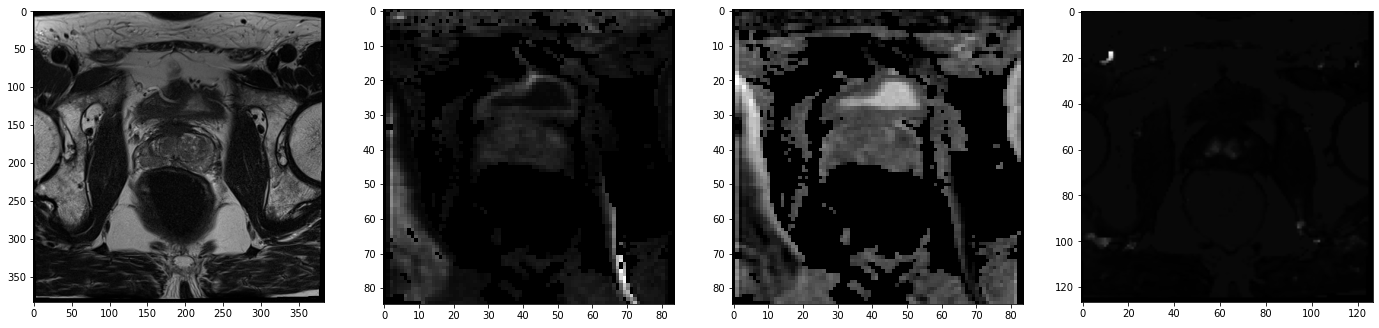

In [41]:
get_vis(rfids, f)